# Продвинутый Python, семинар 13
Лектор: Петров Тимур

Семинаристы: Петров Тимур, Бузаев Федор, Дешеулин Олег, Коган Александра

Spoiler Alert: в рамках курса нельзя изучить ни одну из тем от и до досконально (к сожалению, на это требуется больше времени, чем даже 3 часа в неделю). Но мы попробуем рассказать столько, сколько возможно :)




## Идея! [Напоминание с лекции]

Мы тратили какое-то время на то чтобы поднимать процессы, потоки, а что если не поднимать ничего?!

Давайте представим себе программу которая умеет "переключать внимание" пока какие-то долгие операции выполняются. В целом в этом "переключении внимания" с помощью механизма eventов и состоит смысл coroutine и asyncio.

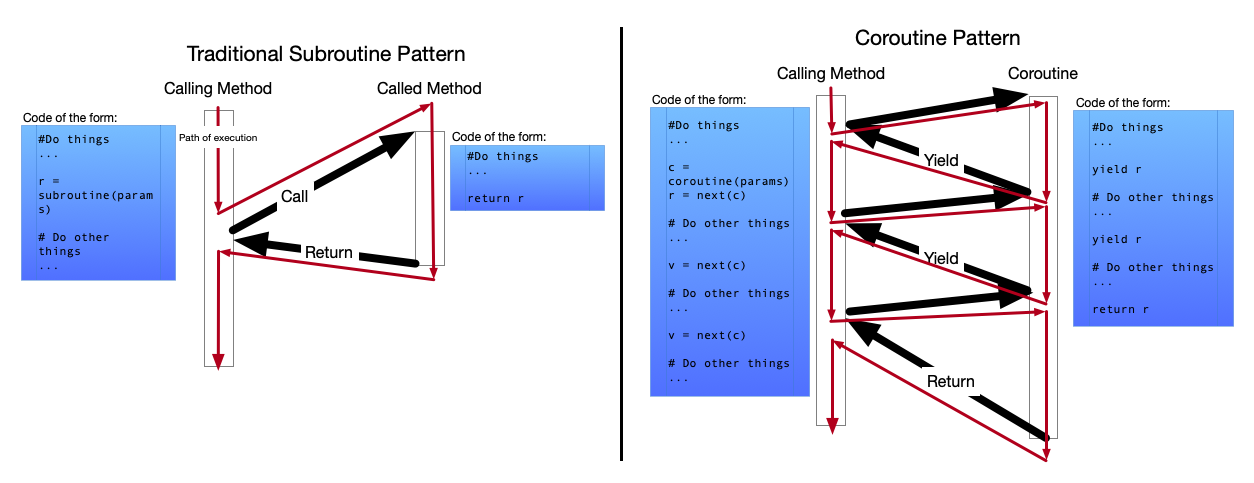

Обратите внимания что здесь нет как таковой многопоточности или подпроцессов. Предпологается, что переключение внимания происходит в рамках одного процесса, в то время как какие-то другие, асинхронные с питоном процессы делают что-то и возвращают результат этого собственно питону. Примеры таких процессов:

* Прием/отправка чего-либо по сети
* Запись/чтение с диска (и соотвественно DB)
* RPC/gRPC (remote procedure call) вызовы другой программы

Какие приложения тогда стоит и не стоит писать с помощью asyncio?

* приложение в котором происходят любые вычисления внутри python, скажем рисование на картинке или проставление запятых в текстах - плохо подходит для этого. Что лучше использовать тогда, кстати говоря? Подсказка: GIL.
* приложение в котором много запросов к сети и сохранение на диск, скажем web-scrapper - отлично подходит
* типичный микросервис, который ходит к базе данных, смотрит что-то и отвечает по сети - идеальный кейс для asyncio
* телеграм-бот

Почему это может быть лучше чем использование thread (потоков):

* Быстрее переключение контекста
* Не нужно менеджерить ничего, все что shared - shared, код работает нативно, нужно только расставить await/async (почти)


Минусы:
* В библиотеке которой вы пользуетесь должна быть поддержка asyncio. Иначе придется позвать thread на помощь
* Вычислительные задачи нельзя распраллелить (как и нельзя было в случае с потоками)

In [ ]:
!pip install fastapi uvicorn aioschedule telebot

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for aioschedule: filename=aioschedule-0.5.2-py3-none-any.whl size=8481 sha256=830bff4629a1a35335d187160ad7439def3f93ea4feb1ae408e81db70940d1f2
  Stored in directory: /root/.cache/pip/wheels/f5/b2/2a/ee29c2ee340b4c4552cda20998765a51eb48563c97c2bb2577
  Created wheel for pyTelegramBotAPI: filename=pyTelegramBotAPI-4.14.0-py3-none-any.whl size=215250 sha256=1c33b02f6f2e0517a9abceafc2eec6bcce1826a494143a57fd483d3bc3eb1328
  Stored in directory: /root/.cache/pip/wheels/25/51/2d/24b40a366c85c37928d5aa36ddf257e5a79fad25e1ecd11b2c
Successfully built aioschedule pyTelegramBotAPI


## Работаем с Asyncio [Напоминание с лекции]

Немного синтаксиса:

* `async def`: cинтаксис для создания асинхронной функции.
* `async with`: cинтаксис для создания асинхронного контекста (что угодно).
* `async for`: cинтаксис для итерирования по асинхронному генератору (пример будет позже)
* `await <name>`: синтаксис отвечающий за то чтобы подождать что-то асинхронное

Давайте проверим что функции действительно не блокируют друг друга:

In [ ]:
import asyncio

async def fetch_data():
  print('start fetching')
  await asyncio.sleep(2) # pause for 2 seconds
  print('done fetching')
  return "data"

async def print_numbers():
  for i in range(10):
    print(i)
    await asyncio.sleep(0.25)

async def main():
  task1 = asyncio.create_task(fetch_data())
  task2 = asyncio.create_task(print_numbers())
  print("Таска1:", task1)
  value = await task1
  print("Дата", value)
  print("Таска2:", task2)
  await task2
  print("а теперь таска1", task1)
  print("а теперь таска2:", task2)

In [ ]:
# если бы мы были не в jupyter notebook:
# asyncio.run(main())
# но jupyter notebook уже поднимает event loop внутри себя (скоро узнаем что это), когда запускает интерпретатор...
await main()

Таска1: <Task pending name='Task-2' coro=<fetch_data() running at <ipython-input-1-f72ca22600bc>:3>>
start fetching
0
1
2
3
4
5
6
7
done fetching
Дата data
Таска2: <Task pending name='Task-3' coro=<print_numbers() running at <ipython-input-1-f72ca22600bc>:12> wait_for=<Future pending cb=[Task.task_wakeup()]>>
8
9
а теперь таска1 <Task finished name='Task-2' coro=<fetch_data() done, defined at <ipython-input-1-f72ca22600bc>:3> result='data'>
а теперь таска2: <Task finished name='Task-3' coro=<print_numbers() done, defined at <ipython-input-1-f72ca22600bc>:9> result=None>



> Обратите внимание что print task ничего не блокирует. Однако, принт про вторую таску произошел после конца первой, потому что перед ним был await.



Давайте убедимся что мы действительно имеем дело c недетерминированными результатами, точно так же как и в реальном вызове многопоточности:

In [ ]:
async def add(x: int, y: int):
    return x + y

async def get_results():
    inputs = [(2,3), (4,5), (5,5), (7,2)]
    # создали список корутин
    cors = [add(x,y) for x,y in inputs]

    # в этом лупе корутины yield как только заканчиваются
    for cor in asyncio.as_completed(cors):
        print(await cor)

In [ ]:
await get_results()

9
10
9
5


In [ ]:
await get_results()

9
5
9
10


## Как это работает внутри питона?

Уже до этого упоминались какие-то event loop и переключения между тасками. Давайте обсудим что это.



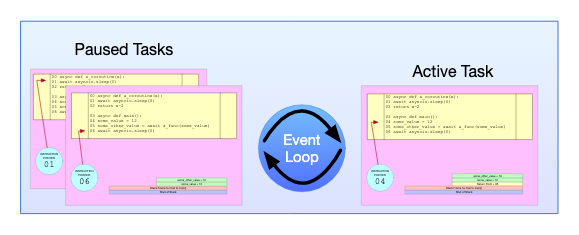

#### Кто такой этот ваш yield?

`yield` это механизм создания генератора. Генератор это ленивый итерируемый объект. Каждый его следующий элемент вычисляется только тогда когда мы зовем метод `next()`.

Когда функция содержит оператор `yield`, она становится генератором. Когда генератор вызывается, он возвращает объект-генератор без фактического выполнения кода внутри функции (поэтому `while True` не блокирует нас).

Каждый вызов метода `next()` на этом объекте-генераторе запускает выполнение кода в функции до тех пор, пока не встретится оператор `yield`. Значение, переданное в `yield`, возвращается как результат вызова `next()`, и выполнение функции приостанавливается до следующего вызова `next()`.

In [ ]:
from time import sleep

def yeilder():
    yield "item 1"
    yield "item 2"
    # откоментируй меня и запусти еще раз и сравни разницу
    # yield from run()

def run():
    while True:
        yield "item 3"
        yield from yeilder()
        yield "item 4"

In [ ]:
core = run()

In [ ]:
for i, item in enumerate(core):
  sleep(0.1)
  print(f"{i}: {item}")
  if i > 15:
      break

0: item 3
1: item 1
2: item 2
3: item 4
4: item 3
5: item 1
6: item 2
7: item 4
8: item 3
9: item 1
10: item 2
11: item 4
12: item 3
13: item 1
14: item 2
15: item 4
16: item 3


Позвать один раз генератор:

In [ ]:
next(core)

'item 1'

#### И причем здесь корутины?

In [ ]:
import time
import random

def countdown(task_id, n):
    while n > 0:
        yield n
        n -= 1
        time.sleep(0.5)
    print(f'{task_id} finished!')

def event_loop():
    tasks = [countdown(0, 10), countdown(1, 5), countdown(2, 7)]
    while tasks:
        task_id = random.randint(0, len(tasks) - 1)
        task = tasks[task_id]
        try:
            x = next(task)
            print(f'{task_id} finished!')
        except StopIteration:
            tasks.remove(task)

event_loop()

res from 1 = 5
res from 0 = 10
res from 2 = 7
res from 2 = 6
res from 1 = 4
res from 0 = 9
res from 1 = 3
res from 1 = 2
res from 1 = 1
1 finished!
res from 0 = 8
res from 1 = 5
res from 1 = 4
res from 1 = 3
res from 1 = 2
res from 1 = 1
res from 0 = 7
res from 0 = 6
1 finished!
res from 0 = 5
res from 0 = 4
res from 0 = 3
res from 0 = 2
res from 0 = 1
0 finished!


Отлично, пока мы ждем yeild мы умеем переключаться между тасками...

In [ ]:
async def add(x: int, y: int):
    return x + y

In [ ]:
type(add)

function

In [ ]:
coro = add(1, 2)

In [ ]:
type(coro)

coroutine

In [ ]:
coro.send, coro.throw

(<function coroutine.send>, <function coroutine.throw>)

In [ ]:
type(yeilder)

function

In [ ]:
type(core)

generator

In [ ]:
core.send, core.throw

(<function generator.send>, <function generator.throw>)

Пупупу... Совпадение - не думаю... И действительно - это не совпадение, корутины это во многом те же самые генераторы, запущенные тум самым event loop так чтобы некоторый набор специальный операций выполнялся не блокируя сам себя.

Например выше была проблема - мы спали в наших генераторах по-настоящему :(
Надо сделать сон и io не блокирующими и в целом получим asyncio.

### Виртуальный сон и наш личный event_loop


Что же делает send?

In [ ]:
async def add(x: int, y: int):
    print(x + y)
    return x + y

In [ ]:
coro = add(1, 2)

In [ ]:
try:
    print(coro.send(None))
except StopIteration:
    print('StopIteration')

3
StopIteration


`send` делает тож самое что и для генератора - запускает его до следующего yield или до момента пока у нас закончится



Отлично, кажется у нас собралось понимание как работает asyncio, напишем сами event loop тогда!

Напоминание: event loop призван крутить все корутины внутри себя.

In [ ]:
import datetime
import heapq
import types
import time


class Task:

    """
    Нам нужна обертка, которая будет хранить все информацию о том
    сколько именно нам нужно сдать до момента пока корутина закончится.

    Сравнения нам нужны чтобы воспользоваться потом кучей без попаболи.

    Это примерно тож самое что и asyncio.Task
    """

    def __init__(self, wait_until, coro):
        self.coro = coro
        self.waiting_until = wait_until

    def __eq__(self, other):
        return self.waiting_until == other.waiting_until

    def __lt__(self, other):
        return self.waiting_until < other.waiting_until

In [ ]:
from types import coroutine

# старый способ создавать корутины, из питона 3.4
# как видите по сути это тот же самый генератор с yield
@coroutine
def sleep(seconds):
    """Приостанавливаем корутину на seconds секунд

    Это будет наша переимплементация asyncio.sleep()
    """
    now = datetime.datetime.now()
    wait_until = now + datetime.timedelta(seconds=seconds)
    # Приостановлив выполнение всех других корутин в стеке вызовов
    actual = yield wait_until
    # продолжаем выполнение со стека вызов
    return actual - now

# обычная корутина, привычная глазу
async def countdown(label, length, *, delay=0):
    print(label, 'waiting', delay, 'seconds before starting countdown')
    delta = await sleep(delay)
    print(label, 'starting after waiting', delta)
    while length:
        print(label, 'T-minus', length)
        waited = await sleep(1)
        length -= 1
    print(label, 'lift-off!')

Напишем event loop который поддерживает скедулинг таких "спящих" тасок.

In [ ]:
class SleepingLoop:
    def __init__(self, *coros):
        self._new = coros
        self._waiting = []

    def run_until_complete(self):
        # Запускаем все наши корутины
        for coro in self._new:
            wait_for = coro.send(None)
            heapq.heappush(self._waiting, Task(wait_for, coro))
        # Пока есть корутины ранимся
        while self._waiting:
            now = datetime.datetime.now()
            # Забираем ближайшую корутину
            task = heapq.heappop(self._waiting)
            if now < task.waiting_until:
                # ждем если надо
                delta = task.waiting_until - now
                time.sleep(delta.total_seconds())
                now = datetime.datetime.now()
            try:
                # Время запустить её до следующего yield
                wait_until = task.coro.send(now)
                heapq.heappush(self._waiting, Task(wait_until, task.coro))
            except StopIteration:
                # Эта корутина все
                pass

In [ ]:
loop = SleepingLoop(countdown('A', 5), countdown('B', 3, delay=2),
                    countdown('C', 4, delay=1))
start = datetime.datetime.now()
loop.run_until_complete()
print('Total elapsed time is', datetime.datetime.now() - start)

A waiting 0 seconds before starting countdown
B waiting 2 seconds before starting countdown
C waiting 1 seconds before starting countdown
A starting after waiting 0:00:00.001902
A T-minus 5
C starting after waiting 0:00:01.001124
C T-minus 4
A T-minus 4
B starting after waiting 0:00:02.001104
B T-minus 3
C T-minus 3
A T-minus 3
B T-minus 2
C T-minus 2
A T-minus 2
B T-minus 1
C T-minus 1
A T-minus 1
B lift-off!
C lift-off!
A lift-off!
Total elapsed time is 0:00:05.008718


Более того, если вы думаете что внутри настоящего питона все совсем не так... То вы правы, выглядит сложнее, но суть та же: https://github.com/python/cpython/blob/304a1b3f3a8ed9a734ef1d098cafccb6725162db/Lib/asyncio/selector_events.py#L1205C5-L1205C20

Вы думаете писать свой личный event loop это моветон? Не-не, это стиль! Например очень популярная библиотека это ускоренный event loop питона: [uvloop](https://github.com/MagicStack/uvloop):


```
import asyncio
import sys

import uvloop

async def main():
    # Main entry-point.
    ...

if sys.version_info >= (3, 11):
    with asyncio.Runner(loop_factory=uvloop.new_event_loop) as runner:
        runner.run(main())
else:
    uvloop.install()
    asyncio.run(main())
```



Еще напрашивается вопрос: а что если мы не знаем сколько ждать...
Для этого используется немного другой механизм, который по сути позволяет выбирать между разными операциями ввода и вывода и делает polling их текущего статуса.

## Жизненые примеры



### Телеграм бот [Напоминание]

Зачем в Телеграм боте нужна асинхронность, спросите вы? Ответ прост: это гораздо быстрее работает (особенно чем больше нагрузка, тем больше вам нужна асинхронность), ну а также это позволяет более эффективно использовать параллельность (которая, сама собой, и так есть в телеграм-боте)

В чем разница? По существу, вместо requests используется aiohttp - асинхронная версия requests, если так можно высказаться

Сделаем сразу вещь, которую нельзя сделать без асинхронности: шедулер! В этом нам поможет бибилиотека aioschedule - асинхронный шедулер.

In [ ]:
import asyncio
import aioschedule
from telebot.async_telebot import AsyncTeleBot

API_TOKEN = ''
bot = AsyncTeleBot(API_TOKEN)


async def beep(chat_id) -> None:
    """Send the beep message."""
    await bot.send_message(chat_id, text='Beep!')
    aioschedule.clear(chat_id)


@bot.message_handler(commands=['help', 'start'])
async def send_welcome(message):
    await bot.reply_to(message, "Hi! Use /set  to set a timer")


@bot.message_handler(commands=['set'])
async def set_timer(message):
    args = message.text.split()
    if len(args) > 1 and args[1].isdigit():
        sec = int(args[1])
        aioschedule.every(sec).seconds.do(beep, message.chat.id).tag(message.chat.id)
    else:
        await bot.reply_to(message, 'Usage: /set ')


@bot.message_handler(commands=['unset'])
def unset_timer(message):
    aioschedule.clean(message.chat.id)


async def scheduler():
    while True:
        await aioschedule.run_pending()
        await asyncio.sleep(1)


async def main():
    await asyncio.gather(bot.infinity_polling(), scheduler())

In [ ]:
await main()

### CPU-heavy, неправильное использование корутины

https://mecha-mind.medium.com/understanding-why-you-wont-need-python-coroutines-99-9-of-the-time-fbb7ac60884d

Давайте возьмем какую-то жутко непонятную имплементацию расстояния Левенштейна (количества отличающихся символов в строках) и даже не будем в нее вникать, просто распараллелим с корутинами!

In [ ]:
# Compute levenshtein distance between str1 and str2
def edit_distance(str1:str, str2:str)->int:
    d:list = [[float("Inf")]*len(str2) for j in range(len(str1))]

    for i in range(len(str1)):
        for j in range(len(str2)):
            if i == 0 and j == 0:
                d[i][j] = 1 if str1[i] != str2[j] else 0
            elif i == 0:
                d[i][j] = d[i][j-1] + 1 if str1[i] != str2[j] else d[i][j-1]
            elif j == 0:
                d[i][j] = d[i-1][j] + 1 if str1[i] != str2[j] else d[i-1][j]
            else:
                if str1[i] == str2[j]:
                    d[i][j] = d[i-1][j-1]
                else:
                    d[i][j] = 1 + min(d[i-1][j-1], d[i-1][j], d[i][j-1])

    return d[-1][-1]

In [ ]:
strings = [
    "I love python course" * 30,
    "I love to study" * 30,
    "I love Higher school of economics" * 30,
    "Kto ya?" * 30
]

In [ ]:
import time
import asyncio

async def calc_and_send(str1, str2):
    res = edit_distance(str1, str2)
    # симулируем отправку результата по сети куда-то
    await asyncio.sleep(0.1)
    return res

def calc_and_send_sync(str1, str2):
    res = edit_distance(str1, str2)
    # симулируем отправку результата по сети куда-то
    time.sleep(0.1)
    return res

In [ ]:
start_time = time.time()
dist_matrix = []
for i in range(len(strings)):
    for j in range(len(strings)):
        dist_matrix.append(asyncio.create_task(calc_and_send(strings[i], strings[j])))
loop = asyncio.get_event_loop()
for item in asyncio.as_completed(dist_matrix):
    await item
time.time() - start_time

4.8727757930755615

In [ ]:
import multiprocessing as mp

In [ ]:
start_time = time.time()
dist_matrix = []
for i in range(len(strings)):
    for j in range(len(strings)):
        dist_matrix.append(mp.Process(target=calc_and_send_sync, args=(strings[i], strings[j])))
        dist_matrix[-1].start()
for proc in dist_matrix:
    proc.join()
time.time() - start_time

3.557293653488159

Как так??

Важно помнить!
Чтобы использование корутин было и по вкусу вкусно и по сути необходимо:
* IO-bounded приложение
* Библиотека которой вы пользуйтесь для IO-операций должна поддерживать "non-blocking IO"

Список таких библиотек: https://github.com/timofurrer/awesome-asyncio

### FastApi

Один из примеров библиотеки поддерживающий asyncio, в том числе и с серверной стороны.

In [ ]:
!pip install fastapi uvicorn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.


In [ ]:
%%writefile main.py
import asyncio
import random
import string

from fastapi import FastAPI
from fastapi.responses import StreamingResponse

app = FastAPI()

@app.get("/random")
async def random_letters(response: StreamingResponse):
    async def fake_video_streamer():
        for i in range(10):
            yield f"byte {i}".encode()
            await asyncio.sleep(0.3)

    return StreamingResponse(fake_video_streamer(), media_type="text/plain")

Overwriting main.py


In [ ]:
import subprocess

process = subprocess.Popen(
    ["uvicorn", "main:app", "--reload", "--host", "0.0.0.0", "--port", "8005"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

In [ ]:
import asyncio
import json
import aiohttp


async def print_random_letters():
    async with aiohttp.ClientSession() as session:
        async with session.get("http://localhost:8005/random") as response:
            async for chunk in response.content.iter_any():
                print(chunk.decode(), end='\n')

In [ ]:
# если бы мы были не в jupyter notebook:
# asyncio.run(main())
# но jupyter notebook уже поднимает event loop внутри себя (скоро узнаем что это), когда запускает интерпретатор...
await print_random_letters()

<class 'aiohttp.client_reqrep.ClientResponse'>
byte 0
byte 1
byte 2
byte 3
byte 4
byte 5
byte 6
byte 7
byte 8
byte 9


In [ ]:
# не забываем процесс закончить
process.terminate()

In [ ]:
# напоминаю как посмотреть логи к subprocess
stdout, stderr = process.communicate()
print(stdout.decode())
print(stderr.decode())

INFO:     127.0.0.1:47648 - "GET /random HTTP/1.1" 200 OK

INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://0.0.0.0:8005 (Press CTRL+C to quit)
INFO:     Started reloader process [13606] using StatReload
INFO:     Started server process [13608]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [13608]
INFO:     Stopping reloader process [13606]



Еще немного материалов для самостоятельного чтения:
1. https://superfastpython.com/python-asyncio
2. https://bbc.github.io/cloudfit-public-docs/asyncio
3. https://www.youtube.com/watch?v=Y4Gt3Xjd7G8
4. https://snarky.ca/how-the-heck-does-async-await-work-in-python-3-5/
5. https://github.com/AndreLouisCaron/a-tale-of-event-loops
6. https://www.pythonsheets.com/appendix/python-concurrent.html